In [7]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils import data

import torchvision.transforms as transforms


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from collections import OrderedDict

import random
from datetime import datetime

In [8]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20_000
NUM_SAMPLES = 50_000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256

In [9]:
# load in the data
input_texts = []  # sentence in original language
target_texts = []  # sentence in target language
target_text_inputs = []  #  sentence in target language offset by 1
t = 0
for line in open("./fra.txt"):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break
    line = line.rstrip()
    # input and targets are separeted by tab
    if "\t" not in line:
        continue

    # split up the input and translation
    input_text, translation = line.split("\t")[:2]

    # make the target input and output
    # recall we'll be using teacher forcing
    target_text = translation + " <eos>"
    target_text_input = "<sos> " + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_text_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 50000


In [10]:
#  tokenize inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)


# get word -> integer mapping
word2idx_inputs = tokenizer_inputs.word_index
print("Found %s unique input tokens" % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)


Found 6090 unique input tokens


In [11]:
# tokenize outputs
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters="")
tokenizer_outputs.fit_on_texts(target_texts + target_text_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_text_inputs)

# get word -> integer mapping for outputs
word2idx_outputs = tokenizer_outputs.word_index
print("Found %s unique output tokens" % len(word2idx_outputs))


# store number of output wors for later
# remember to add 1 since indexing start at 1
num_words_output = len(word2idx_outputs) + 1


# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

Found 17859 unique output tokens


In [12]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(
    target_sequences_inputs, maxlen=max_len_target, padding="post"
)
print("decoder_data.shape:", decoder_inputs.shape)
print("decoder_data[0]:", decoder_inputs[0])

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding="post")

encoder_data.shape: (50000, 7)
encoder_data[0]: [ 0  0  0  0  0  0 25]
decoder_data.shape: (50000, 15)
decoder_data[0]: [ 2 82 13  0  0  0  0  0  0  0  0  0  0  0  0]


In [13]:
# load in pre-trained word vectors
print("loading word vectors ...")
word2vec_path = '../Lazyprogrammer/large_files/glove.6B/glove.6B.%sd.txt'
word2vec = {}
with open(
    os.path.join(word2vec_path % EMBEDDING_DIM)
) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2]
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype="float32")
        word2vec[word] = vec
    print("Found %s word vectors." % len(word2vec))

loading word vectors ...
Found 400000 word vectors.


In [14]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [15]:
# one-hot the targets (can't use sparse categorical cross entropy)
decoder_targets_one_hot = np.zeros(
    (len(input_sequences), max_len_target, num_words_output), dtype="float32"
)
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [16]:
# build data set
class Translation(data.Dataset):
    def __init__(self):
        self.encoder_in = torch.from_numpy(encoder_inputs).int()
        self.decoder_in = torch.from_numpy(decoder_inputs).int()
        self.decoder_out = torch.from_numpy(decoder_targets).float()
        #self.decoder_out = torch.from_numpy(decoder_targets_one_hot).float()
    def __len__(self):
        return len(encoder_inputs)

    def __getitem__(self, idx):
        
        encoder_in = self.encoder_in[idx]
        decoder_in = self.decoder_in[idx]
        decoder_out = self.decoder_out[idx]
        
    
        return encoder_in, decoder_in, decoder_out


In [17]:
# instantiate dataset
translation_dataset = Translation()

In [18]:
data_loader = torch.utils.data.DataLoader(
    dataset=translation_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE)

In [19]:
for inputs, inputs_d, targets in data_loader:
    print(inputs.shape, inputs_d.shape, targets.shape)
    break

torch.Size([64, 7]) torch.Size([64, 15]) torch.Size([64, 15])


In [20]:
# load pre-trained word embeddings into an embedding layer
# freeze the layer
embedding_layer = nn.Embedding(num_words, EMBEDDING_DIM)  # vocab size  # embedding dim
embedding_layer.weight = nn.Parameter(torch.from_numpy(embedding_matrix).float())
embedding_layer.requires_grad = False


In [21]:
# some configuration
# EMBEDDING_DIM = 100
# LATENT_DIM = 256
# T encoder = 4
class Encoder(nn.Module):
    def __init__(self, input_size,embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size # LATENT_DIM
        self.num_layers = num_layers # 1 or 2

        self.embedding = embedding_layer # vocab size x EMBEDDING_DIM
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p, batch_first=True) # -> N x T x hidden

    def forward(self, x):
        # x shape: (N, T encoder) where N is batch size

        embedding = self.dropout(self.embedding(x)) # (N, T encoder, EMBEDDING_DIM)
        # embedding shape: # (N, T encoder, EMBEDDING_DIM)

        _ , (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)
        #  outputs shape:  (N, T encoder , hidden_size) 
        # hidden, cell : (num_layers, hidden_size)
        return hidden, cell

In [22]:
# EMBEDDING_DIM = 100
# LATENT_DIM = 256
# T decoder = 11
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size # LATENT_DIM
        self.num_layers = num_layers  # 1 or 2
 
        self.embedding = nn.Embedding(input_size, embedding_size) # input size = vocab fr size = num_words_output
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p, batch_first=True)  # -> N x T decoder x hidden
        self.fc = nn.Linear(hidden_size, output_size) # ->  N x T x output size

    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (N, 1), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(1) # -> (N, 1)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (N, 1, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (N, 1, hidden_size)

        predictions = self.fc(outputs)

        # predictions shape: (N, 1, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(1)

        return predictions, hidden, cell
        # 


In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        # source = encoder_inputs
        # target = encoder_inputs
        batch_size = source.shape[0] # source (N, T_encoder)
        target_len = target.shape[1] # target (N, T_decoder)
        target_vocab_size = num_words_output # check this is correct num_words = len(word2idx_outputs) + 1 

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device) # (N, T_decoder, vocab)

        hidden, cell = self.encoder(source) # (num_layers, hidden_size)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[:,0] # (N, 1)

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            #hidden, cell = hidden.squeeze(1), cell.squeeze(1)
            output, hidden, cell = self.decoder(x, hidden, cell)

            # Store next output prediction
            outputs[:,t,:] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[:,t] if random.random() < teacher_force_ratio else best_guess

        return outputs


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_encoder = num_words
input_size_decoder = num_words_output
output_size = num_words_output
encoder_embedding_size = EMBEDDING_DIM
decoder_embedding_size = EMBEDDING_DIM
hidden_size = LATENT_DIM  # Needs to be the same for both RNN's
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

# Training hyperparameters
num_epochs = 300
learning_rate = 0.001
batch_size = 64

In [25]:
encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

In [26]:
model = Seq2Seq(encoder_net, decoder_net).to(device)

In [27]:
#model = torch.load('./translation.pth')

In [28]:
# loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate, weight_decay=1e-3)
model.train()

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(6091, 100)
    (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(17860, 100)
    (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=256, out_features=17860, bias=True)
  )
)

In [29]:
sentence = "I love dogs"
num_epochs = 50


train_losses = np.zeros(num_epochs)
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    #checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    #save_checkpoint(checkpoint)

    #model.eval()

    
    #translated_sentence = translate_sentence(sentence)

    #print(f"Translated example sentence: \n {translated_sentence}")

    #model.train()

    for batch_idx, batch in enumerate(data_loader):
        train_loss = []
        # Get input and targets and get to cuda
        # encoder_in, decoder_in, decoder_out
        encoder_in, decoder_in, target = batch
        encoder_in, decoder_in, target = encoder_in.to(device), decoder_in.to(device), target.to(device)
        #inp_data = batch.src.to(device)
        #target = batch.trg.to(device)

        # Forward prop
        output = model(encoder_in, decoder_in)

        # Output is of shape (batch_size, trg_len, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have batch_size * output_words that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        #output = output[1:].reshape(-1, output.shape[2])
        #target = target[1:].reshape(-1)
        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)
        
        optimizer.zero_grad()
        loss = criterion(output, target.long())

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()
        train_loss.append(loss.item())
    
    epoch_loss = np.mean(train_loss)           
    train_losses[epoch] = epoch_loss
    print(f'Loss: {epoch_loss:.4f}')
        # Plot to tensorboard
        #writer.add_scalar("Training loss", loss, global_step=step)
        #step += 1


[Epoch 0 / 50]
Loss: 2.2200
[Epoch 1 / 50]
Loss: 2.0264
[Epoch 2 / 50]
Loss: 1.6159
[Epoch 3 / 50]
Loss: 1.6062
[Epoch 4 / 50]
Loss: 1.5242
[Epoch 5 / 50]
Loss: 1.7400
[Epoch 6 / 50]
Loss: 1.2838
[Epoch 7 / 50]
Loss: 1.6582
[Epoch 8 / 50]
Loss: 1.4400
[Epoch 9 / 50]
Loss: 1.4825
[Epoch 10 / 50]
Loss: 1.4067
[Epoch 11 / 50]
Loss: 1.0943
[Epoch 12 / 50]
Loss: 1.0234
[Epoch 13 / 50]
Loss: 1.2690
[Epoch 14 / 50]
Loss: 1.2933
[Epoch 15 / 50]
Loss: 1.2088
[Epoch 16 / 50]
Loss: 1.0734
[Epoch 17 / 50]
Loss: 1.0536
[Epoch 18 / 50]
Loss: 1.2210
[Epoch 19 / 50]
Loss: 1.2157
[Epoch 20 / 50]
Loss: 0.9527
[Epoch 21 / 50]
Loss: 0.9808
[Epoch 22 / 50]
Loss: 1.1917
[Epoch 23 / 50]
Loss: 1.0818
[Epoch 24 / 50]
Loss: 0.9600
[Epoch 25 / 50]
Loss: 1.0902
[Epoch 26 / 50]
Loss: 1.0358
[Epoch 27 / 50]
Loss: 0.9822
[Epoch 28 / 50]
Loss: 1.2579
[Epoch 29 / 50]
Loss: 1.1025
[Epoch 30 / 50]
Loss: 1.1055
[Epoch 31 / 50]
Loss: 1.0346
[Epoch 32 / 50]
Loss: 0.9254
[Epoch 33 / 50]
Loss: 0.9248
[Epoch 34 / 50]
Loss: 0.

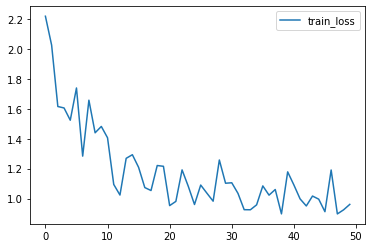

In [35]:
# some plots
plt.plot(train_losses, label="train_loss")
plt.legend()
plt.show()

In [36]:
torch.save(model, './translation.pth')

In [37]:
# map indexes back into real words
# so wwe can view the results
idx2word_eng = {v: w for w, v in word2idx_inputs.items()}
idx2word_trans = {v: w for w, v in word2idx_outputs.items()}

In [38]:
def decode_sequence(input_seq):
    # encode the input as state vectors.
    input_seq = input_seq.to(device)
    with torch.no_grad():
        h, c = encoder_net(input_seq)

        # generate empty target seq of length 1
        target_seq = torch.zeros(1).int().to(device)

        # populate the first character of target sequence with the start character
        # NOTE: tokenizer lower cases all words
        target_seq[0] = word2idx_outputs["<sos>"]

        # if we get this we break
        eos = word2idx_outputs["<eos>"]

        # create translation
        output_sentence = []
        for _ in range(max_len_target):
            output_tokens, h, c = decoder_net(target_seq, h, c)

            # get next word
            idx = output_tokens.argmax(1).item()

            # end of sentence EOS
            if eos == idx:
                break

            word = ""
            if idx > 0:
                word = idx2word_trans[idx]
                output_sentence.append(word)

            # update the decoder input
            # which is just the word just generated
            target_seq[0] = idx
            #states_value = [h, c]

        return " ".join(output_sentence)

In [39]:
while True:
    # do some translation
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i : i + 1]
    input_seq = torch.from_numpy(input_seq).to(device)
    translation = decode_sequence(input_seq)
    print("_")
    print("Input:", input_texts[i])
    print("Translation:", translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith("n"):
        break


_
Input: Did you go out?
Translation: sortie ?


Continue? [Y/n] y


_
Input: Thanks for the help.
Translation: pour la aide.


Continue? [Y/n] y


_
Input: I'm here for good.
Translation: suis là pour moment.


Continue? [Y/n] y


_
Input: He decided not to go.
Translation: a décidé ne pas pas


Continue? [Y/n] y


_
Input: My house was on fire.
Translation: voiture était en feu.


Continue? [Y/n] y


_
Input: All that has changed.
Translation: cela a changé.


Continue? [Y/n] y


_
Input: I really need to go.
Translation: me vraiment vraiment aller. aller.


Continue? [Y/n] y


_
Input: I was ready.
Translation: prête.


Continue? [Y/n] y


_
Input: It depends on you.
Translation: dépend de vous.


Continue? [Y/n] y


_
Input: We're the last.
Translation: sommes les derniers.


Continue? [Y/n] y


_
Input: It'll break.
Translation: va se se


Continue? [Y/n] y


_
Input: Can you deliver this?
Translation: livrer ceci ?


Continue? [Y/n] y


_
Input: Tom would cry.
Translation: pleurerait.


Continue? [Y/n] y


_
Input: You're tough.
Translation: es dur.


Continue? [Y/n] y


_
Input: Is that understood?
Translation: est-il ?


Continue? [Y/n] y


_
Input: He's a biologist.
Translation: est biologiste.


Continue? [Y/n] y


_
Input: They went crazy.
Translation: devinrent folles.


Continue? [Y/n] y


_
Input: Tom is unmoved.
Translation: est indifférent.


Continue? [Y/n] y


_
Input: The paint's drying.
Translation: peinture est en train de sécher.


Continue? [Y/n] n


In [40]:
# just som tests

In [ ]:
def translate_sentence(sentence="I love dogs"):
    sentence = [sentence]
    print(sentence)
    sequence = tokenizer_inputs.texts_to_sequences(sentence)
    print(sequence)
    sequence = pad_sequences(sequence, maxlen=max_len_input)
    print(sequence)
    sequence = torch.Tensor(sequence).int()
    print(sequence)
    translation = decode_sequence(sequence)
    print(translation)
    return translation

In [ ]:
sentence = "I love dogs"
translate_sentence(sentence)

In [ ]:
sentence = [sentence]
sequence = tokenizer_inputs.texts_to_sequences(sentence)
print(sequence)

In [ ]:
idx2word_eng[495]

In [ ]:
i = np.random.choice(len(input_texts))
print(i)
input_seq = encoder_inputs[i : i + 1]
print(input_seq)
input_seq = torch.from_numpy(input_seq).to(device)
translation = decode_sequence(input_seq)
print(translation)

In [ ]:
print(sequence)
sequence = pad_sequences(sequence, maxlen=max_len_input)
print(sequence)
